In [2]:
# INFO: execute shell commands directly by prefixing them with '!'
!pip install numpy scipy matplotlib seaborn sympy scipy autograd pandas symengine

In [3]:
import numpy as np
import scipy.integrate
import scipy.optimize
from scipy.integrate import odeint

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.optimize import fsolve

import autograd.numpy as np
from autograd import grad, jacobian

import pandas as pd

# for the 3D plot
from mpl_toolkits import mplot3d

import symengine
import sympy

sns.set(style='whitegrid')

In [4]:
# define the initial system state (aka x, y, z positions in space)
initial_state = np.array([0.1, 0, 0])
#initial_state = np.array([8.485,8.485,27])


# the range for the separatrix calculation
xStimulusRange = [0, 6]
yStimulusRange = [0, 6]
zStimulusRange = [0, 6]

# define the system parameters sigma, rho, and beta
sigma = 10.
rho   = 28.
beta  = 8./3.

args = (sigma, rho, beta)

t = np.linspace(0, 30, 300)

In [5]:
def solveODESystem(current_state, t, sigma, rho, beta):
  
    x, y, z = current_state
    
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    return np.array([dx_dt, dy_dt, dz_dt])

In [6]:
def calculateFixPoints(current_state, sigma, rho, beta):
  
    x, y, z = current_state
    
    dx_dt = sigma * (y - x)
    dy_dt = x * (rho - z) - y
    dz_dt = x * y - beta * z
    
    return np.array([dx_dt, dy_dt, dz_dt])

Calculate the trajectories

In [7]:
trajectorieValue = pd.DataFrame(odeint(solveODESystem, initial_state, t, args=(sigma, rho, beta)), columns=['x','y','z'])
print(trajectorieValue)

             x          y          z
0     0.100000   0.000000   0.000000
1     0.127649   0.256531   0.001152
2     0.397944   0.866295   0.013074
3     1.300550   2.835447   0.140302
4     4.219009   9.100986   1.482146
..         ...        ...        ...
295  -1.378435  -2.701633  19.106652
296  -2.825731  -4.659605  15.294068
297  -5.576251  -9.483735  14.276211
298 -10.853056 -17.032843  20.846098
299 -14.708808 -13.877747  36.208688

[300 rows x 3 columns]


In [8]:
def exploreDGLSurface(initial_state, i, args):
 # print("first=",initial_state)
  placeHolderState = initial_state + i

  # new found fix point    
  # round after 8 digits after the decimal place
  # NOTE: the reason for this is that fsolve solves the system with a deviation
  newFixPoint = (fsolve(calculateFixPoints, x0=placeHolderState, args=args).round(8))

  return newFixPoint

def checkFoundedFixPoint(newFixPoint, fixedPoints):
  # check whether the fixed point was not found already    

  if np.isin(newFixPoint,fixedPoints).all() == False:
    fixedPoints.append(newFixPoint)

  return fixedPoints

# surfaceScope = wie weit der Käfer die Oberfläche einsehen kann
# surfaceStep = iteration Schritt
def iterateOverDGLSurface(initial_state=np.ndarray, surfaceScope=0, surfaceStep=0, args=()):

  iterationSpace = np.linspace(0,surfaceScope,int(surfaceScope/surfaceStep) + 1)
  fixedPoints = [] 
  
  for i in iterationSpace:  
    # TEMP: not a good coding practice
    
    newFixPoint = exploreDGLSurface(initial_state, i, args)
    fixedPoints = checkFoundedFixPoint(newFixPoint, fixedPoints)

    newFixPoint = exploreDGLSurface(initial_state, -i, args)
    fixedPoints = checkFoundedFixPoint(newFixPoint, fixedPoints)

  # turn list into tuple
  fixedPoints = tuple(fixedPoints)

  return fixedPoints

calculate the fixed points of the system

In [9]:
fixedPoints = iterateOverDGLSurface(initial_state, surfaceScope = 10, surfaceStep = 1, args = (sigma, rho, beta))

In [10]:
fixedPoints

(array([0., 0., 0.]),
 array([ 8.48528137,  8.48528137, 27.        ]),
 array([-8.48528137, -8.48528137, 27.        ]))

In [11]:
variables = symengine.symbols('x y z') # Define variables

# Define the function
f = symengine.sympify(['sigma * (y - x)', 'x * (rho - z) - y', 'x * y - beta * z']) 

# initialize Jacobian matrix
J = symengine.zeros(len(f),len(variables)) 

# Fill Jacobian matrix with entries
for i, fi in enumerate(f):
    for j, s in enumerate(variables):
        J[i,j] = symengine.diff(fi, s)

# convert J to a sympy matrix
stringJ = sympy.Matrix(J)

In [12]:
stringJ

Matrix([
[ -sigma, sigma,     0],
[rho - z,    -1,    -x],
[      y,     x, -beta]])

In [13]:
# TODO: generalize this approach 

fixedPointsDict = {}
numFixPoints = 0

for i in fixedPoints:

  placeHolderDict = {}
  placeHolderDict['x'] = i[0]
  placeHolderDict['y'] = i[1]
  placeHolderDict['z'] = i[2]
  fixedPointsDict[numFixPoints] = placeHolderDict
  numFixPoints += 1
  
# eval the J matrix
parameterDict = dict()
parameterDict['sigma'] = 10.
parameterDict['rho'] = 28.
parameterDict['beta'] = 8./3.

In [14]:
def controlEigenvalues(eigenvalues):
  for i in eigenvalues:
    if i > 0:
      return 'unstable'
  return 'stable' 

Close to rho=24.74 the real part of the eigenvalues are positive. From this value of rho all the equilibria are unstable.

In [15]:
unstableFixedPoints = []

for i,j in fixedPointsDict.items():
  # merge the parameter dict with the fixed point solution
  mergedDict = dict(**parameterDict, **j)

  numberJ = np.array(np.array(stringJ.subs(mergedDict)),dtype=float)
  
  # calculate the eigenvalues
  eigenvalues = np.linalg.eigvals(numberJ)
 
  # check whether the fixed point is stable or unstable 
  if controlEigenvalues(eigenvalues) == 'unstable':
    unstableFixedPoints.append(j)

# NOTE: Temporary solution
unstableFixedPointsTuple = ()
for i in unstableFixedPoints:
    unstableFixedPointsTuple += (np.array(list(i.values())),)

print(unstableFixedPoints)

[{'x': 0.0, 'y': 0.0, 'z': 0.0}, {'x': 8.48528137, 'y': 8.48528137, 'z': 27.0}, {'x': -8.48528137, 'y': -8.48528137, 'z': 27.0}]


In [16]:
# For computing the separatrix, we start at the saddle and then integrate the 
# system backwards in time, starting just off of the saddle point.
def newSeparatrix(fixedPoints, xStimulusRange, yStimulusRange, zStimulusRange, sigma, rho, beta, t_max=50, eps=5e-6, 
                           color='tomato', lw=3):

    # Negative time function to integrate to compute separatrix
    def rhs(current_state, t):
        # Unpack variables
        x, y, z = current_state
    
        # Stop integrating if we get the edge of where we want to integrate
        if xStimulusRange[0] < x < xStimulusRange[1] and yStimulusRange[0] < y < yStimulusRange[1] and zStimulusRange[0] < z < zStimulusRange[1]:
            return -solveODESystem(current_state, t, sigma, rho, beta)
        else:
            return np.array([0, 0, 0]) 

    # Parameters for building separatrix
    t = np.linspace(0, t_max, 400)
    
    # Build upper right branch of separatrix
    initial_state = fixedPoints + eps
    ab_upper = scipy.integrate.odeint(rhs, initial_state, t)

    # Build lower left branch of separatrix
    initial_state = fixedPoints - eps
    ab_lower = scipy.integrate.odeint(rhs, initial_state, t)

    # Concatenate, reversing lower so points are sequential
    variableList = ['x', 'y', 'z']
    createDataFrameDict = {}
    for index, variable in enumerate(variableList):

      createDataFrameDict[variable] = list(np.concatenate((ab_lower[::-1,index], ab_upper[:,index])))

    # create the separatrix time series as a pandas dataframe
    pdDataFrame = pd.DataFrame(data=createDataFrameDict)
        
    return pdDataFrame

/usr/local/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


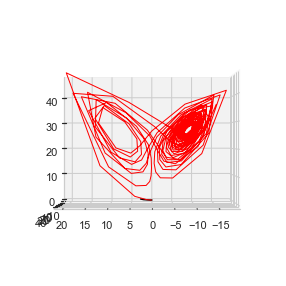

In [18]:
tmax = 50

fig = plt.figure(figsize=(5,5))
ax = plt.axes(projection='3d')

timeSeriesList = []
for i in unstableFixedPointsTuple:
  pdDataFrame = newSeparatrix(i, xStimulusRange, yStimulusRange, zStimulusRange, sigma, rho, beta, t_max=tmax)
  pdDataFrame2 = newSeparatrix(i, xStimulusRange, yStimulusRange, zStimulusRange, sigma, rho, beta, t_max=-tmax)

  timeSeriesList.append(pdDataFrame)
  timeSeriesList.append(pdDataFrame2)

for i in timeSeriesList:
  
  # split the array column-wise
  splittedList = np.hsplit(i.values,len(initial_state))
  ax.plot3D(splittedList[0].flatten(),splittedList[1].flatten(), splittedList[2].flatten(), color='black')

# plot the trajectorie line
x,y,z= trajectorieValue['x'], trajectorieValue['z'],trajectorieValue['z']
lines = ax.plot(x, y, z, '-', c='red')
plt.setp(lines, linewidth=1)

# rotate the plot
ax.view_init(0, 90)

plt.show()
